<a href="https://colab.research.google.com/github/dvschultz/dataset-tools/blob/master/CLIP_Dataset_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to use CLIP Zero-Shot on your own classification dataset

This notebook provides an example of how to benchmark CLIP's zero shot classification performance on your own classification dataset.

[CLIP](https://openai.com/blog/clip/) is a new zero shot image classifier relased by OpenAI that has been trained on 400 million text/image pairs across the web. CLIP uses these learnings to make predictions based on a flexible span of possible classification categories.

CLIP is zero shot, that means **no training is required**. 


# Download and Install CLIP Dependencies

In [ ]:
#installing some dependencies, CLIP was release in PyTorch
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

import numpy as np
import torch
import os

print("Torch version:", torch.__version__)
os.kill(os.getpid(), 9)

## Clone the CLIP repo

In [1]:
#clone the CLIP repository
!git clone https://github.com/openai/CLIP.git
%cd CLIP

Cloning into 'CLIP'...
remote: Enumerating objects: 90, done.
remote: Total 90 (delta 0), reused 0 (delta 0), pack-reused 90
Unpacking objects: 100% (90/90), done.
/content/CLIP


## Import Dataset

Next we need to import a dataset. You can upload a zip directly to Colab (drag and drop it into the Files tab on your left), sync your Drive, or import using gdown.

In [ ]:
#sync Drive account
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!gdown --id 1JSkcE52EtKkJKn66ZLlupIfXqVtxx0cj -O /content/minerals-min1024.zip
%cd /content/
!unzip minerals-min1024.zip
%cd CLIP

## Create Tokens
CLIP will use pieces of text, called tokens, to compare your image against. Below we will create a single token to test with.

I rcommend experimenting with phrases you use. CLIP can respond to  particular sentence structures for better or worse responses.

In [ ]:
captions = ['A photograph containing text','A photograph without text' ]

# Single Image Scoring

Let’s start by looking at a single image and a single caption. CLIP can take the image and provide a probablity for how likely the model thinks the caption and image match.

[[0.9263  0.07367]]


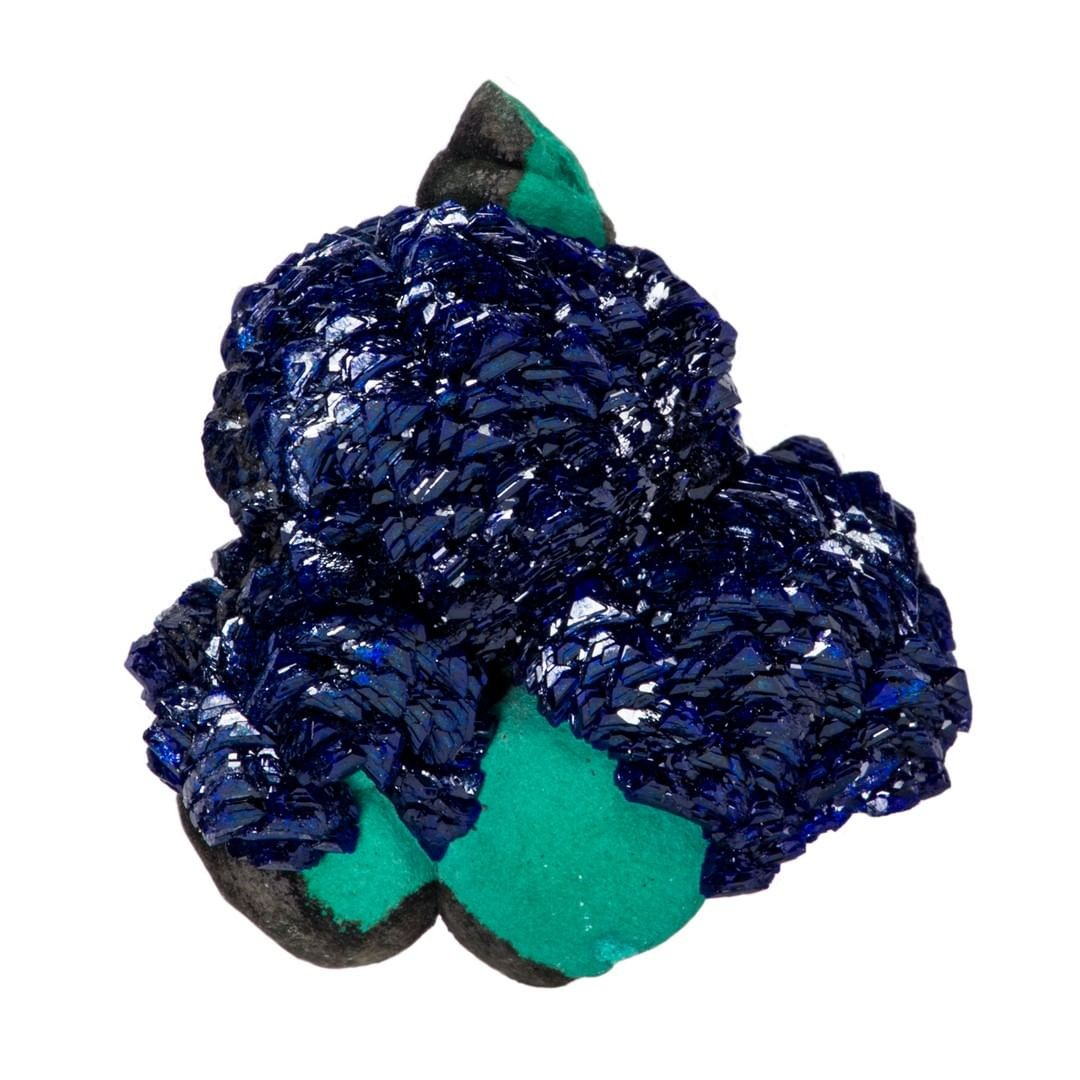

A photograph of a single gemstone


In [ ]:
import torch
import clip
from PIL import Image
import glob
from IPython.display import Image as Img, display

def argmax(iterable):
    return max(enumerate(iterable), key=lambda x: x[1])[0]

captions = ['A photograph of a single gemstone','A photograph of multiple gemstones' ]
img = '/content/72229387_233170594333680_2980116756105763390_n.jpg'

device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)

#define our target classifications, you can should experiment with these strings of text as you see fit
text = clip.tokenize(captions).to(device)

image = transform(Image.open(img)).unsqueeze(0).to(device)
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    print(probs)
    pred = captions[argmax(list(probs)[0])]
    display(Img(filename=img, width=400))
    print(pred)

## Sorting into two classes
Below we’ll extend the above example to look at every image in a folder and sort the images into two folders. We’ll use the probability score and take the class that gets the higher probability. I recommend using tokens that express som binary operation.

As this proceess runs the image, probability score, and predictions will be displayed. Pay close attention to false positives and consider editing your tokens if you see too many.

In [ ]:
import os
import torch
import clip
from PIL import Image
import glob
from IPython.display import Image as Img, display

def argmax(iterable):
    return max(enumerate(iterable), key=lambda x: x[1])[0]

imgs = glob.glob('/content/minerals-min1024/*.jpg')
captions = ['A photograph of a single gemstone','A photograph of multiple gemstones' ]

fpaths = []
for f in captions:
    fpath = '/content/'+f.replace(' ','_')
    fpaths.append(fpath)
    if not os.path.exists(fpath):
        os.makedirs(fpath)
print(fpaths)

device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)

#define our target classifications, you can should experiment with these strings of text as you see fit
text = clip.tokenize(captions).to(device)

for img in imgs:
    image = transform(Image.open(img)).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
        
        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
        pred = captions[argmax(list(probs)[0])]
        display(Img(filename=img, width=400))
        print(probs)
        print(pred)

        img_name = img.split('/')[-1]
        path = fpaths[argmax(list(probs)[0])] + '/' + img_name
        !cp {img} {path}

## Sorting into multiple classes (Max probabilty)

So far we’ve only looked at two classes, but you can technically use any number of categories. This example will only sort by maximum probability, so each image will only end up in one class at a time.

In [ ]:
import os
import torch
import clip
from PIL import Image
import glob
from IPython.display import Image as Img, display

def argmax(iterable):
    return max(enumerate(iterable), key=lambda x: x[1])[0]

captions = ['A photograph of a gemstone on a black background','A photograph of a gemstone on a white background','A photograph of a gemstone on a gradient background' ]
imgs = glob.glob('/content/minerals-min1024/*.jpg')

fpaths = []
for f in captions:
    fpath = '/content/'+f.replace(' ','_')
    fpaths.append(fpath)
    if not os.path.exists(fpath):
        os.makedirs(fpath)
print(fpaths)

device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)

#define our target classifications, you can should experiment with these strings of text as you see fit
text = clip.tokenize(captions).to(device)

for img in imgs:
    image = transform(Image.open(img)).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
        
        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
        pred = captions[argmax(list(probs)[0])]
        display(Img(filename=img, width=400))
        print(probs)
        print(pred)

        img_name = img.split('/')[-1]
        path = fpaths[argmax(list(probs)[0])] + '/' + img_name
        !cp {img} {path}

## Sorting into multiple classes (Greedy)

You might want to sort an image into multiple folders. To do this you’ll ned to set a minimum probability score.

This can be pretty tricky. Because all probability scores add up to one, you’ll need to find a good value that will define "confidence, but not under- or over-confidence."

['/content/A_photograph_of_a_yellow_gemstone', '/content/A_photograph_of_a_yellow_gemstone_on_a_black_background', '/content/A_photograph_of_a_blue_gemstone']


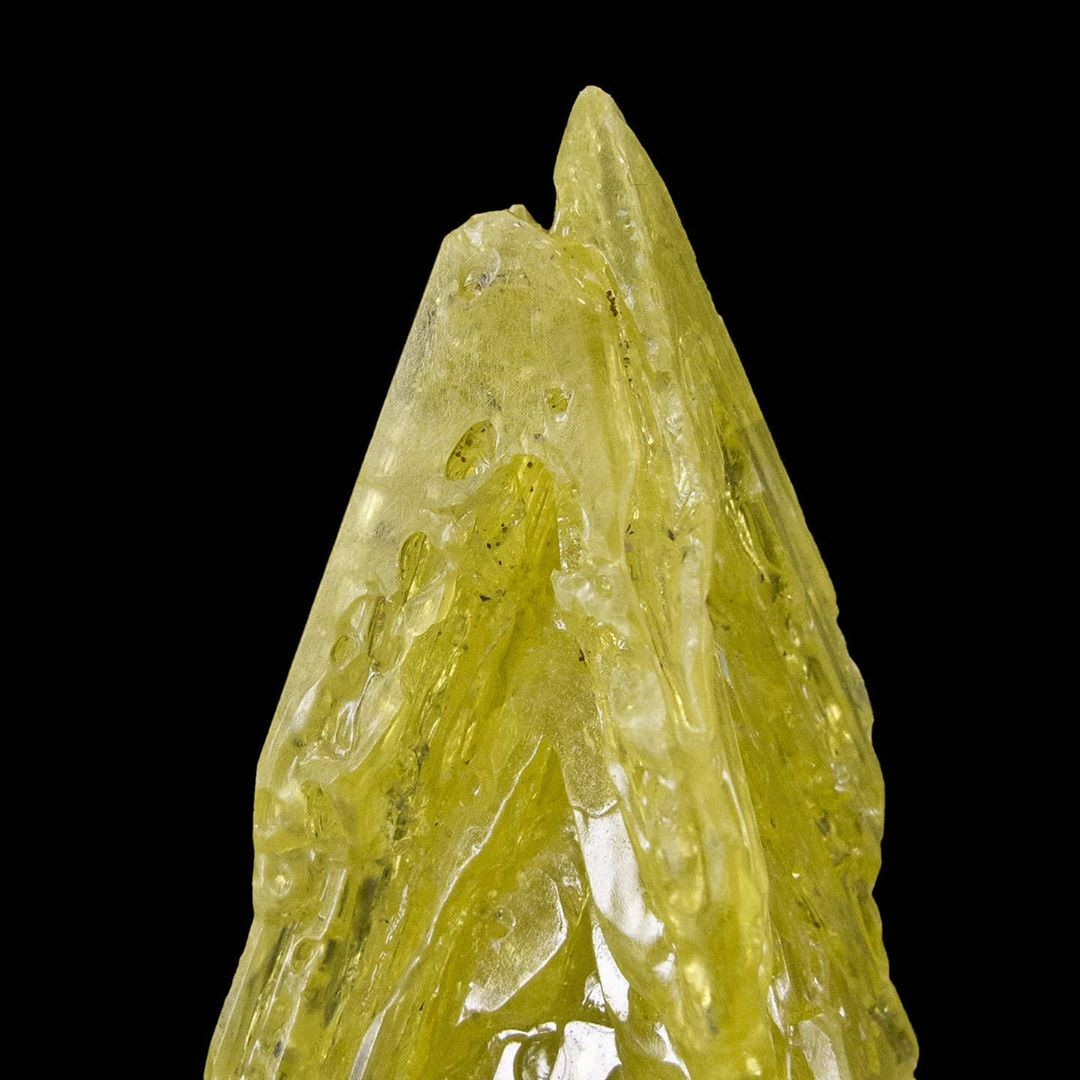

[[6.655e-01 3.345e-01 1.374e-04]]
A photograph of a yellow gemstone
A photograph of a yellow gemstone on a black background


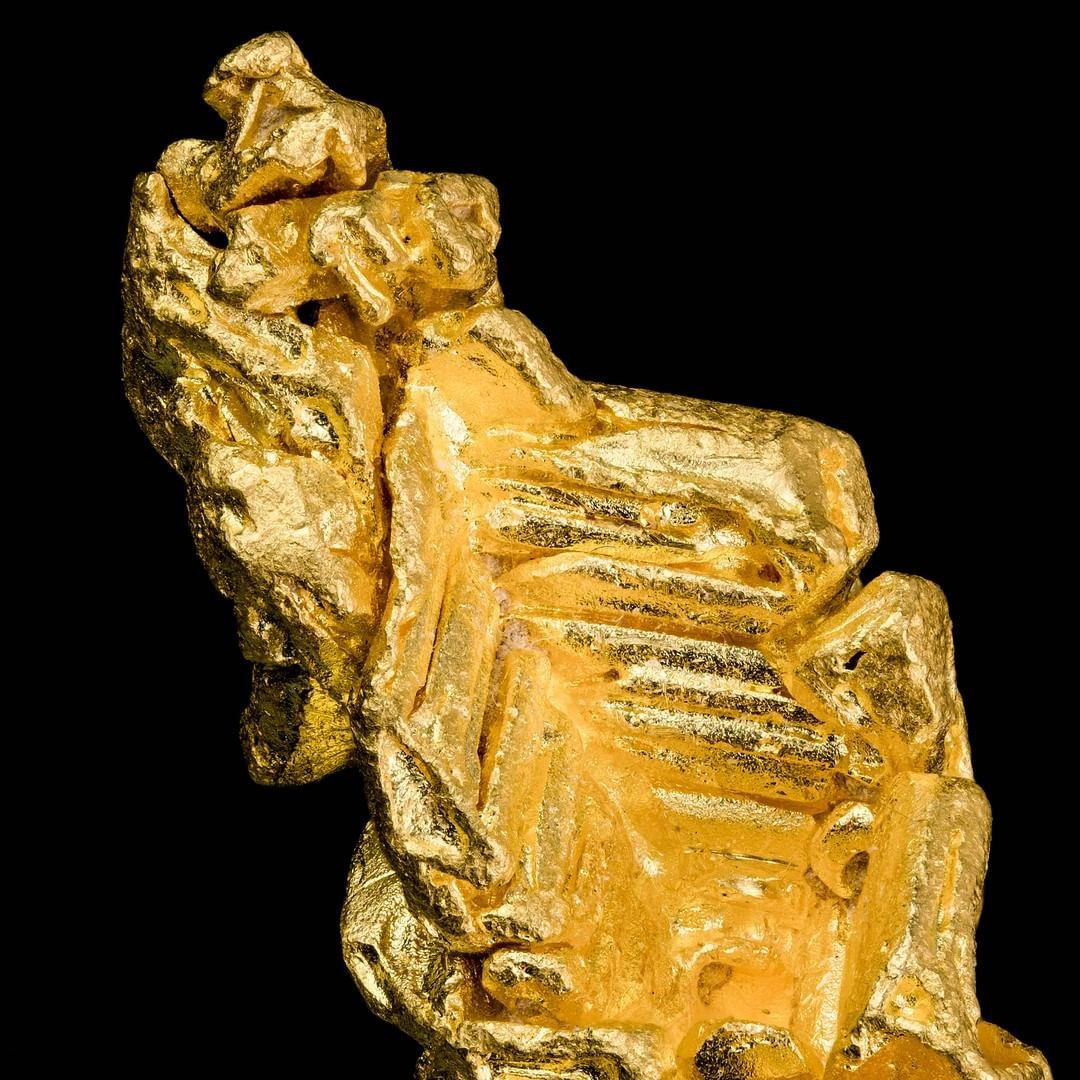

[[6.367e-01 3.628e-01 3.061e-04]]
A photograph of a yellow gemstone
A photograph of a yellow gemstone on a black background


In [20]:
import os
import torch
import clip
from PIL import Image
import glob
import numpy as np
from IPython.display import Image as Img, display

def argmax(iterable):
    return max(enumerate(iterable), key=lambda x: x[1])[0]

captions = ['A photograph of a yellow gemstone','A photograph of a yellow gemstone on a black background','A photograph of a blue gemstone' ]
imgs = glob.glob('/content/minerals-min1024/*.jpg')
imgs = ['/content/minerals-min1024/100481775_881455889038814_607293032477522603_n.jpg','/content/minerals-min1024/100667852_647174005869995_6071646807884906331_n.jpg']
min_prob = .2

fpaths = []
for f in captions:
    fpath = '/content/'+f.replace(' ','_')
    fpaths.append(fpath)
    if not os.path.exists(fpath):
        os.makedirs(fpath)
print(fpaths)

device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)

#define our target classifications, you can should experiment with these strings of text as you see fit
text = clip.tokenize(captions).to(device)

for img in imgs:
    image = transform(Image.open(img)).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
        
        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
        pred = captions[argmax(list(probs)[0])]
        display(Img(filename=img, width=400))
        print(probs)

        img_name = img.split('/')[-1]
        for i in range(len(probs[0])):
            if(probs[0][i] >= min_prob):
                print(captions[i])
                path = fpaths[i] + '/' + img_name
                !cp {img} {path}